## Installing MediaPipe

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 53.4 MB/s eta 0:00:00


## Configure Project path, Train and Test paths

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import glob

proj_path = '/content/drive/MyDrive/Magnimind/Face_detection/MP'
os.chdir(proj_path)

In [4]:
train_dir = os.path.join(proj_path, '..','train')
test_dir = os.path.join(proj_path, '..', 'test')

In [5]:
train_img_search_path = os.path.join(train_dir, '*')
train_img_paths = glob.glob(train_img_search_path)

test_img_search_path = os.path.join(test_dir, '*')
test_img_paths = glob.glob(test_img_search_path)

In [6]:
len(train_img_paths)

2080

In [7]:
len(test_img_paths)

300

## Visualize one image from train and test set

In [8]:
import random
random_train_img_path = random.choice(train_img_paths)
random_test_img_path = random.choice(test_img_paths)

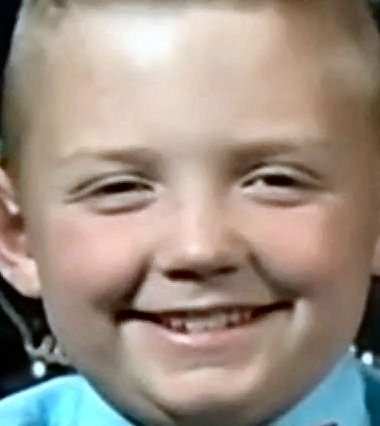

In [9]:
import cv2
from google.colab.patches import cv2_imshow

train_image = cv2.imread(random_train_img_path)
cv2_imshow(train_image)

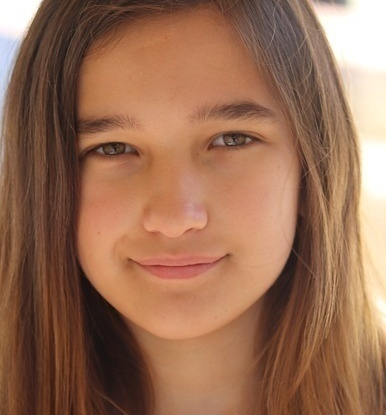

In [10]:
test_image = cv2.imread(random_test_img_path)
cv2_imshow(test_image)

## Extracting Facial landmarks

In [11]:
import mediapipe as mp
import time

class FeatureExtractor:
    MAX_RETRIES = 5

    def __init__(self, img_dir=None):
        # Configuring image directory
        self.img_dir = img_dir
        self.img_paths = self._load_img_paths()

        # Initializing facemesh object
        self.face_mesh = mp.solutions.face_mesh.FaceMesh()

    def _load_img_paths(self):
        if self.img_dir == None:
            return None

        img_search_path = os.path.join(self.img_dir, '*')
        return glob.glob(img_search_path)

    def _extract_features_from_image(self, img_path):

        # Extract info from the image path
        file_name = os.path.basename(img_path)
        label, image_num_str, _ = file_name.split('.')
        image_num = int(image_num_str)

        # Read image and process it to detect face landmarks
        image = cv2.imread(img_path)

        # converting BGR to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image
        results = self.face_mesh.process(image)

        # No landmarks detected
        if not results.multi_face_landmarks:
            return None

        # Start collecting image features
        curr_img_feature = {
            "img_path": img_path,
            "image_num": image_num,
            "label": label
        }

        # Collect landmark features
        for landmarks in results.multi_face_landmarks:
            for idx, landmark in enumerate(landmarks.landmark):
                key_x = f"landmark_{idx}_x"
                key_y = f"landmark_{idx}_y"
                key_z = f"landmark_{idx}_z"

                curr_img_feature[key_x] = landmark.x
                curr_img_feature[key_y] = landmark.y
                curr_img_feature[key_z] = landmark.z

        return curr_img_feature

    def get_features(self, img_paths=None):
        all_features = []

        if img_paths == None:
            img_paths = self.img_paths

        if img_paths == None:
            print('Configure the image path before extracting the features!')
            return None

        for img_path in img_paths:
            retries = 0
            while retries < self.MAX_RETRIES:
                features = self._extract_features_from_image(img_path)
                if features:
                    all_features.append(features)
                    break
                else:
                    print(f"Retry attempt {retries + 1}/{self.MAX_RETRIES} for image: {img_path}")
                    retries += 1
                    time.sleep(1)

            if retries >= self.MAX_RETRIES:
                print(f"Failed to detect facial landmarks for image: {img_path} after {self.MAX_RETRIES} retries")
        return all_features

In [12]:
train_extractor = FeatureExtractor(train_dir)
train_features = train_extractor.get_features()

test_extractor = FeatureExtractor(test_dir)
test_features = test_extractor.get_features()

Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.1130.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.1129.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.1134.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.448.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.5.jpg
Retry attempt 1/5 for image: /content/drive/MyDrive/Magnimind/Face_detection/MP/../train/Autistic.764.jpg


In [13]:
import pandas as pd
train_df = pd.DataFrame(train_features)
test_df = pd.DataFrame(test_features)

In [14]:
train_df.head()

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,...,landmark_464_z,landmark_465_x,landmark_465_y,landmark_465_z,landmark_466_x,landmark_466_y,landmark_466_z,landmark_467_x,landmark_467_y,landmark_467_z
0,/content/drive/MyDrive/Magnimind/Face_detectio...,839,Autistic,0.511593,0.709910,-0.040127,0.517181,0.670308,-0.168715,0.515403,...,-0.057532,0.587559,0.500262,-0.077599,0.768636,0.474503,-0.021161,0.784336,0.468965,-0.021392
1,/content/drive/MyDrive/Magnimind/Face_detectio...,825,Autistic,0.566339,0.733220,-0.065258,0.575596,0.677747,-0.127426,0.568713,...,0.001300,0.609449,0.556148,-0.015839,0.738344,0.541875,0.039996,0.751471,0.531839,0.042270
2,/content/drive/MyDrive/Magnimind/Face_detectio...,817,Autistic,0.437217,0.744490,-0.077209,0.426740,0.685478,-0.165941,0.433244,...,-0.018598,0.488665,0.551752,-0.038808,0.656447,0.535078,0.003090,0.674554,0.525373,0.003349
3,/content/drive/MyDrive/Magnimind/Face_detectio...,845,Autistic,0.533727,0.797597,-0.053682,0.549781,0.762331,-0.169223,0.540980,...,-0.035548,0.601406,0.623819,-0.057016,0.766676,0.603243,0.013871,0.782729,0.596054,0.015662
4,/content/drive/MyDrive/Magnimind/Face_detectio...,844,Autistic,0.524054,0.774706,-0.052582,0.505436,0.710976,-0.152662,0.512779,...,-0.039194,0.528307,0.568924,-0.058087,0.683886,0.525732,-0.016595,0.697740,0.517121,-0.017281


In [15]:
test_df.head()

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,...,landmark_464_z,landmark_465_x,landmark_465_y,landmark_465_z,landmark_466_x,landmark_466_y,landmark_466_z,landmark_467_x,landmark_467_y,landmark_467_z
0,/content/drive/MyDrive/Magnimind/Face_detectio...,100,Autistic,0.727391,0.710138,-0.117875,0.753489,0.581854,-0.193980,0.723864,...,0.048919,0.737665,0.421433,0.016144,0.890724,0.401811,0.169311,0.903891,0.394724,0.177334
1,/content/drive/MyDrive/Magnimind/Face_detectio...,108,Autistic,0.457443,0.710929,-0.091133,0.437796,0.633989,-0.193647,0.445459,...,-0.020685,0.482040,0.471925,-0.044690,0.660659,0.437236,0.013672,0.679693,0.424461,0.015152
2,/content/drive/MyDrive/Magnimind/Face_detectio...,106,Autistic,0.452099,0.779923,-0.042830,0.453784,0.726497,-0.181251,0.455887,...,-0.063696,0.546055,0.521134,-0.084867,0.749610,0.499630,-0.035831,0.771000,0.490222,-0.036383
3,/content/drive/MyDrive/Magnimind/Face_detectio...,1,Autistic,0.457504,0.754957,-0.085740,0.470419,0.687706,-0.211908,0.467041,...,-0.034361,0.565713,0.535771,-0.059295,0.783299,0.529403,0.008190,0.804902,0.522787,0.009052
4,/content/drive/MyDrive/Magnimind/Face_detectio...,103,Autistic,0.362426,0.740446,-0.046425,0.366750,0.668341,-0.156865,0.372543,...,-0.048113,0.491366,0.545638,-0.066218,0.686309,0.559731,-0.032427,0.705237,0.556214,-0.034047


In [16]:
train_df.shape

(2080, 1407)

In [17]:
test_df.shape

(300, 1407)

In [18]:
train_df['label'].value_counts()

Autistic        1270
Non_Autistic     810
Name: label, dtype: int64

In [19]:
train_df['label'].value_counts(normalize=True)

Autistic        0.610577
Non_Autistic    0.389423
Name: label, dtype: float64

In [20]:
test_df['label'].value_counts()

Autistic        150
Non_Autistic    150
Name: label, dtype: int64

In [21]:
train_df[train_df.isna().any(axis=1)]

,img_path,image_num,label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,...,landmark_464_z,landmark_465_x,landmark_465_y,landmark_465_z,landmark_466_x,landmark_466_y,landmark_466_z,landmark_467_x,landmark_467_y,landmark_467_z


In [22]:
train_df.to_csv('train_3D.csv', index=False)
test_df.to_csv('test_3D.csv', index=False)